load input face image:  ./example/input/cam01.jpg
detected one face
estimate head pose
data normalization, i.e. crop the face image
load gaze estimator
load the pre-trained model:  ./ckpt/epoch_24_ckpt.pth.tar
prepare the output


/var/folders/7r/ngjz5wpd0v1gp423_2v8cssc0000gn/T/ipykernel_65046/3853343059.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pre_trained_model_path, m

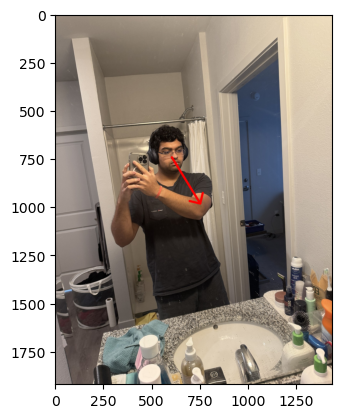

In [4]:
import os
import cv2
import dlib
from imutils import face_utils
import numpy as np
import torch
from torchvision import transforms
from model import gaze_network
import matplotlib.pyplot as plt 

from head_pose import HeadPoseEstimator

trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),  # this also convert pixel value from [0,255] to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def estimateHeadPose(landmarks, face_model, camera, distortion, iterate=True):
    ret, rvec, tvec = cv2.solvePnP(face_model, landmarks, camera, distortion, flags=cv2.SOLVEPNP_EPNP)

    ## further optimize
    if iterate:
        ret, rvec, tvec = cv2.solvePnP(face_model, landmarks, camera, distortion, rvec, tvec, True)

    return rvec, tvec

def draw_gaze(image_in, face_center, pitchyaw, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    (h, w) = image_in.shape[:2]
    length = np.min([h, w]) / 2.0
    pos = face_center
    # pos = h // 2, w // 2
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1]) * np.cos(pitchyaw[0])
    dy = -length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(pos).astype(np.int32)),
                   tuple(np.round([pos[0] + dx, pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)
    
    arrow_start = pos
    arrow_end = pos[0] + dx, pos[1] + dy

    return image_out, arrow_start, arrow_end

def normalizeData_face(img, face_model, landmarks, hr, ht, cam):
    ## normalized camera parameters
    focal_norm = 960  # focal length of normalized camera
    distance_norm = 600  # normalized distance between eye and camera
    roiSize = (224, 224)  # size of cropped eye image

    ## compute estimated 3D positions of the landmarks
    ht = ht.reshape((3, 1))
    hR = cv2.Rodrigues(hr)[0]  # rotation matrix
    Fc = np.dot(hR, face_model.T) + ht  # rotate and translate the face model
    two_eye_center = np.mean(Fc[:, 0:4], axis=1).reshape((3, 1))
    nose_center = np.mean(Fc[:, 4:6], axis=1).reshape((3, 1))
    # get the face center
    face_center = np.mean(np.concatenate((two_eye_center, nose_center), axis=1), axis=1).reshape((3, 1))

    ## ---------- normalize image ----------
    distance = np.linalg.norm(face_center)  # actual distance between eye and original camera

    z_scale = distance_norm / distance
    cam_norm = np.array([  # camera intrinsic parameters of the virtual camera
        [focal_norm, 0, roiSize[0] / 2],
        [0, focal_norm, roiSize[1] / 2],
        [0, 0, 1.0],
    ])
    S = np.array([  # scaling matrix
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, z_scale],
    ])

    hRx = hR[:, 0]
    forward = (face_center / distance).reshape(3)
    down = np.cross(forward, hRx)
    down /= np.linalg.norm(down)
    right = np.cross(down, forward)
    right /= np.linalg.norm(right)
    R = np.c_[right, down, forward].T  # rotation matrix R

    W = np.dot(np.dot(cam_norm, S), np.dot(R, np.linalg.inv(cam)))  # transformation matrix

    img_warped = cv2.warpPerspective(img, W, roiSize)  # warp the input image

    # head pose after normalization
    hR_norm = np.dot(R, hR)  # head pose rotation matrix in normalized space
    hr_norm = cv2.Rodrigues(hR_norm)[0]  # convert rotation matrix to rotation vectors

    # normalize the facial landmarks
    num_point = landmarks.shape[0]
    landmarks_warped = cv2.perspectiveTransform(landmarks, W)
    landmarks_warped = landmarks_warped.reshape(num_point, 2)

    return img_warped, landmarks_warped

if __name__ == '__main__':
    img_file_name = './example/input/cam01.jpg'
    print('load input face image: ', img_file_name)
    image = cv2.imread(img_file_name)

    predictor = dlib.shape_predictor('./modules/shape_predictor_68_face_landmarks.dat')
    # face_detector = dlib.cnn_face_detection_model_v1('./modules/mmod_human_face_detector.dat')
    face_detector = dlib.get_frontal_face_detector()  ## this face detector is not very powerful
    detected_faces = face_detector(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1) ## convert BGR image to RGB for dlib
    if len(detected_faces) == 0:
        print('warning: no detected face')
        exit(0)
    print('detected one face')
    shape = predictor(image, detected_faces[0]) ## only use the first detected face (assume that each input image only contains one face)
    shape = face_utils.shape_to_np(shape)
    landmarks = []
    for (x, y) in shape:
        landmarks.append((x, y))
    landmarks = np.asarray(landmarks)

    # load camera information
    cam_file_name = './example/input/cam00.xml'  # this is camera calibration information file obtained with OpenCV
    if not os.path.isfile(cam_file_name):
        print('no camera calibration file is found.')
        exit(0)
    fs = cv2.FileStorage(cam_file_name, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
    camera_distortion = fs.getNode('Distortion_Coefficients').mat()

    print('estimate head pose')
    # load face model
    face_model_load = np.loadtxt('face_model.txt')  # Generic face model with 3D facial landmarks
    landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
    face_model = face_model_load[landmark_use, :]
    # estimate the head pose,
    ## the complex way to get head pose information, eos library is required,  probably more accurrated
    # landmarks = landmarks.reshape(-1, 2)
    # head_pose_estimator = HeadPoseEstimator()
    # hr, ht, o_l, o_r, _ = head_pose_estimator(image, landmarks, camera_matrix[cam_id])
    ## the easy way to get head pose information, fast and simple
    facePts = face_model.reshape(6, 1, 3)
    landmarks_sub = landmarks[[36, 39, 42, 45, 31, 35], :]
    landmarks_sub = landmarks_sub.astype(float)  # input to solvePnP function must be float type
    landmarks_sub = landmarks_sub.reshape(6, 1, 2)  # input to solvePnP requires such shape
    hr, ht = estimateHeadPose(landmarks_sub, facePts, camera_matrix, camera_distortion)

    # data normalization method
    print('data normalization, i.e. crop the face image')
    img_normalized, landmarks_normalized = normalizeData_face(image, face_model, landmarks_sub, hr, ht, camera_matrix)

    print('load gaze estimator')
    model = gaze_network()
    # model.cuda() # comment this line out if you are not using GPU
    pre_trained_model_path = './ckpt/epoch_24_ckpt.pth.tar'
    if not os.path.isfile(pre_trained_model_path):
        print('the pre-trained gaze estimation model does not exist.')
        exit(0)
    else:
        print('load the pre-trained model: ', pre_trained_model_path)
    ckpt = torch.load(pre_trained_model_path, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['model_state'], strict=True)  # load the pre-trained model
    model.eval()  # change it to the evaluation mode
    input_var = img_normalized[:, :, [2, 1, 0]]  # from BGR to RGB
    input_var = trans(input_var)
    input_var = torch.autograd.Variable(input_var.float())
    input_var = input_var.view(1, input_var.size(0), input_var.size(1), input_var.size(2))  # the input must be 4-dimension
    pred_gaze = model(input_var)  # get the output gaze direction, this is 2D output as pitch and raw rotation
    pred_gaze = pred_gaze[0] # here we assume there is only one face inside the image, then the first one is the prediction
    pred_gaze_np = pred_gaze.cpu().data.numpy()  # convert the pytorch tensor to numpy array

    print('prepare the output')
    # draw the facial landmarks
    landmarks_normalized = landmarks_normalized.astype(int) # landmarks after data normalization
    for (x, y) in landmarks_normalized:
        cv2.circle(img_normalized, (x, y), 5, (0, 255, 0), -1)
        
    

    
    detected_face = detected_faces[0]
    face_start_row = detected_face.top()
    face_start_col = detected_face.left()
    face_end_row = detected_face.bottom()
    face_end_col = detected_face.right()
    
    
    face_center = (face_end_col + face_start_col) // 2, (face_end_row + face_start_row) // 2


    
    gaze_image, arrow_start, arrow_end = draw_gaze(image, face_center, pred_gaze_np, thickness=10)
    gaze_image = cv2.cvtColor(gaze_image, cv2.COLOR_BGR2RGB)
    plt.imshow(gaze_image)
    plt.show()
    
    
    # face_patch_gaze = draw_gaze(img_normalized, pred_gaze_np)  # draw gaze direction on the normalized face image
    # output_path = 'example/output/results_gaze.jpg'
    # print('save output image to: ', output_path)
    # face_patch_gaze = cv2.cvtColor(face_patch_gaze, cv2.COLOR_BGR2RGB)
    # plt.imshow(face_patch_gaze)
    # plt.show()
    # print()
